In [2]:
import csv
import pandas as pd
import numpy as np
import gzip
from patsy import dmatrix
import shutil
import matplotlib.colors as mcolors
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
import dataframe_image as dfi
import dask.dataframe as dd
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import TwoSlopeNorm
from sklearn.linear_model import LogisticRegression
import pyarrow.csv as pv
from matplotlib.colors import LogNorm
from sklearn import tree
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.linear_model import LinearRegression
import pyarrow.parquet as pq
from sklearn.tree import export_graphviz
import graphviz
from scipy.optimize import curve_fit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from lifelines.utils import k_fold_cross_validation
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.tree import plot_tree
from sklearn.datasets import make_regression
import seaborn as sns
import dask.dataframe as dd
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
import time
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
from numpy.polynomial.polynomial import Polynomial
import sys
from sklearn.inspection import partial_dependence
from sklearn.ensemble import RandomForestClassifier  
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import lifelines
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.interpolate import UnivariateSpline
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingClassifier
from sksurv.tree import SurvivalTree
from sksurv.util import Surv
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, log_loss
import shap
from lifelines.statistics import logrank_test
from sklearn.model_selection import KFold
from sksurv.ensemble import RandomSurvivalForest

In [3]:
general = ['YEAR', 'MORTDODY', 'MORTSTAT'] # general

mental_w = ['WRYBILLS', 'WRYRET', 'WRYHCCST', 'WRYCCPAY', 'WRYHOUS', 'WRYMEDCST', 'WRYSTDLIV'] # anxiety 1,2,3,4
            
mental_med = ['WORRX', 'DEPRX'] # mediaction 1,2
            
mental_freq = ['WORFREQ', 'DEPFREQ'] # frequency 1,2,3,4,5
             
mental_a = ['AHOPELESS', 'ANERVOUS', 'ARESTLESS', 'ASAD', 'AWORTHLESS', 'AEFFORT'] # other 0,1,2,3,4
            
mental_a_infer = ['AFEELINT1MO'] # feeling interfer with life 1,2,3,4 --- USED ONLY FOR PEOPLE WHO SAID YES TO AT LEAST ONE OF metal4

#mental6 = ['DEPFEELEVL', 'WORFEELEVL'] # 1,2,3 (0 niu - to be used)

In [4]:
df = pd.read_csv('thesis__data_res.csv', usecols = general + mental_w + mental_med + mental_freq + mental_a + mental_a_infer)

In [5]:
# remove samples whose moratality status is not followed
df = df[(df['MORTSTAT'] == 1) | (df['MORTSTAT'] == 2)]

# define dead as 1 and alive as 0
df['MORTSTAT'] = df['MORTSTAT'].replace(2, 0)

In [6]:
# fix universe of W features
df = df[df[mental_w].isin([1, 2, 3, 4]).all(axis=1)] 

# fix universe of medication features
df = df[df[mental_med].isin([1, 2]).all(axis=1)]

# fix universe of frquency features
df = df[df[mental_freq].isin([1, 2, 3, 4, 5]).all(axis=1)]

# fix universe of A features
df = df[df[mental_a].isin([0, 1, 2, 3, 4]).all(axis=1)]

# remove unknow nad refused to responf from AFEELINT1MO
df = df[df[mental_a_infer].isin([0, 1, 2, 3, 4, 5]).all(axis=1)]
# make AFEELINT1MO orndial nad fix universe
df.loc[df['AFEELINT1MO'] == 0, 'AFEELINT1MO'] = 5

print(f'Number of samples with no NIU values is ', len(df))

Number of samples with no NIU values is  71636


In [7]:
# add column that counts number of years between survey and death/censoring
df['TIMETOEVENT'] = df.apply(
    lambda row: row['MORTDODY'] - row['YEAR'] if row['MORTSTAT'] == 1 else 2019 - row['YEAR'], 
    axis=1)

In [7]:
#_______________________________________________________________________________________________________________________________

In [8]:
#KM
kmf = KaplanMeierFitter()

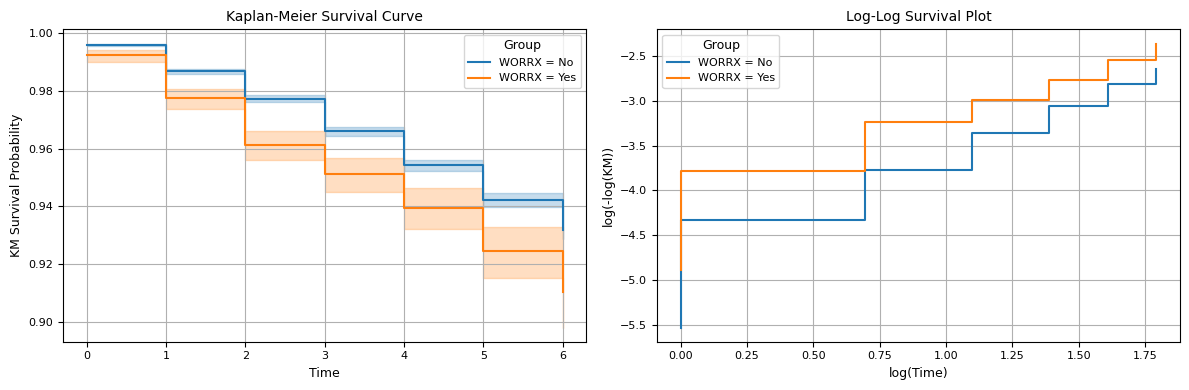

In [183]:
plt.figure(figsize=(12, 4)) 

labels = {1: "WORRX = No", 2: "WORRX = Yes"}

# first subplot: Kaplan-Meier survival function
plt.subplot(1, 2, 1)  
for i in [1, 2]:
    mask = df['WORRX'] == i
    kmf = KaplanMeierFitter()  
    kmf.fit(df.loc[mask, 'TIMETOEVENT'], event_observed=df.loc[mask, 'MORTSTAT'], label=labels[i])
    kmf.plot_survival_function(ci_show=True)

# customize first plot
plt.xlabel("Time", fontsize=9)
plt.ylabel("KM Survival Probability", fontsize=9)
plt.title("Kaplan-Meier Survival Curve", fontsize=10)
plt.legend(title="Group", fontsize=8, title_fontsize=9, loc='best')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True)

# second subplot: log-log survival plot
plt.subplot(1, 2, 2)
for i in [1, 2]:
    mask = df['WORRX'] == i
    kmf = KaplanMeierFitter()
    kmf.fit(df.loc[mask, 'TIMETOEVENT'], event_observed=df.loc[mask, 'MORTSTAT'], label=labels[i])
    kmf.plot_loglogs()  

# customize second plot
plt.xlabel("log(Time)", fontsize=9)
plt.ylabel("log(-log(KM))", fontsize=9)
plt.title("Log-Log Survival Plot", fontsize=10)
plt.legend(title="Group", fontsize=8, title_fontsize=9, loc='best')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True)

plt.tight_layout()  
plt.show()

In [184]:
#_______________________________________________________________________________________________________________________________

In [19]:
# split data into trainign and test set
df_train, df_test = train_test_split(df, test_size=0.2, random_state=21)

In [34]:
len(df[df['MORTSTAT']==1])/len(df)

0.03940756044446926

In [20]:
# M1

In [27]:
# train cox
cph = CoxPHFitter()
cph.fit(df_train[mental_w + mental_med + mental_freq + 
           mental_a + mental_a_infer + ['TIMETOEVENT', 'MORTSTAT']] , duration_col='TIMETOEVENT', event_col='MORTSTAT')

summary_df = cph.summary  
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 57308 total observations, 55049 right-censored observations>
             duration col = 'TIMETOEVENT'
                event col = 'MORTSTAT'
      baseline estimation = breslow
   number of observations = 57308
number of events observed = 2259
   partial log-likelihood = -23257.28
         time fit was run = 2025-02-22 22:02:54 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
WRYBILLS    -0.14      0.87      0.05           -0.24           -0.05                0.79                0.95
WRYRET       0.35      1.43      0.03            0.29            0.42                1.34                1.52
WRYHCCST    -0.04      0.96      0.04           -0.12            0.03                0.88                1.03
WRYCCPAY     0.02      1.02      0.04           -0.07            0.10                0.94                1.10
WRYHOUS      0.17      1.19      0.05            0.08            0.27                1.08                1.30
WRYMEDCST    0.15      1.16      0.04            0.08            0.22                1.08                1.25
WRYSTDLIV    0.02      1.02      0.04           -0.06            0.10                0.94                1.10
WORRX        0.25      1.29      0.10            0.07            0.44                1.07                1.56
DEPRX        0.12      1.13      0.10           -0.07            0.31                0.93                1.37
WORFREQ      0.13      1.13      0.03            0.08            0.18                1.08                1.19
DEPFREQ     -0.02      0.98      0.03           -0.09            0.04                0.92                1.04
AHOPELESS   -0.06      0.94      0.05           -0.15            0.02                0.86                1.03
ANERVOUS    -0.20      0.82      0.03           -0.27           -0.14                0.76                0.87
ARESTLESS   -0.06      0.94      0.03           -0.12           -0.01                0.89                0.99
ASAD         0.17      1.19      0.04            0.10            0.24                1.11                1.28
AWORTHLESS   0.25      1.28      0.04            0.17            0.33                1.18                1.39
AEFFORT      0.22      1.24      0.03            0.16            0.27                1.18                1.31
AFEELINT1MO -0.16      0.85      0.03           -0.22           -0.09                0.80                0.91

             cmp to     z      p  -log2(p)
covariate                                 
WRYBILLS       0.00 -2.95 <0.005      8.31
WRYRET         0.00 10.83 <0.005     88.44
WRYHCCST       0.00 -1.12   0.26      1.93
WRYCCPAY       0.00  0.39   0.70      0.52
WRYHOUS        0.00  3.53 <0.005     11.25
WRYMEDCST      0.00  4.24 <0.005     15.46
WRYSTDLIV      0.00  0.50   0.62      0.69
WORRX          0.00  2.63   0.01      6.88
DEPRX          0.00  1.23   0.22      2.18
WORFREQ        0.00  4.90 <0.005     19.99
DEPFREQ        0.00 -0.74   0.46      1.13
AHOPELESS      0.00 -1.42   0.16      2.67
ANERVOUS       0.00 -5.99 <0.005     28.80
ARESTLESS      0.00 -2.16   0.03      5.01
ASAD           0.00  4.85 <0.005     19.61
AWORTHLESS     0.00  5.97 <0.005     28.63
AEFFORT        0.00  7.80 <0.005     47.17
AFEELINT1MO    0.00 -4.87 <0.005     19.74
---
Concordance = 0.68
Partial AIC = 46550.57
log-likelihood ratio test = 879.33 on 18 df
-log2(p) of ll-ratio test = 579.33

In [28]:
print(f'APLL_is: {cph.score(df_train, scoring_method="log_likelihood"):.4f}')
print(f'APLL_os: {cph.score(df_test, scoring_method="log_likelihood"):.4f}')

APLL_is: -0.4058
APLL_os: -0.3504


In [29]:
print(f'C_is: {cph.score(df_train, scoring_method="concordance_index"):.3f}')
print(f'C_os: {cph.score(df_test, scoring_method="concordance_index"):.3f}')

C_is: 0.678
C_os: 0.694


In [17]:
# APLL CV
def cross_validate_cph_APLL(df, k):
    
    # intialize
    kf = KFold(n_splits=k, shuffle=True, random_state=20)
    # empty list for k-fold log-losses
    apll_list = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(df)):
        train_df, test_df = df.iloc[train_idx], df.iloc[test_idx]

        # fit Cox model
        cph = CoxPHFitter()
        cph.fit(train_df, duration_col='TIMETOEVENT', event_col='MORTSTAT')

        # compute survival probabilities for all test samples
        apll_avr = cph.score(df_train, scoring_method="log_likelihood")
        
        apll_list.append(apll_avr)

    return apll_list

list_apll = cross_validate_cph_APLL(df[mental_w + mental_med + mental_freq + 
                                       mental_a + mental_a_infer +  ['TIMETOEVENT', 'MORTSTAT']], 5)
print(f'APLL CV: {np.mean(list_apll):.4f}')

APLL CV: -0.4059


In [18]:
# predict the survival function for each individual
survival_probs_train_cox = cph.predict_survival_function(df_train)
survival_probs_test_cox = cph.predict_survival_function(df_test)

# extract 1y survival probabilities
survival_prob_1y_train_cox = survival_probs_train_cox.iloc[1] 
survival_prob_1y_test_cox = survival_probs_test_cox.iloc[1] 
# extract 3y survival probabilities
survival_prob_3y_train_cox = survival_probs_train_cox.iloc[3] 
survival_prob_3y_test_cox = survival_probs_test_cox.iloc[3] 


# get 1-year event status based on TIMETOEVENT and MORTSTAT
status_1y_train_cox = np.where((df_train["MORTSTAT"] == 1) & (df_train["TIMETOEVENT"] <= 1), 0, 1)
status_1y_test_cox = np.where((df_test["MORTSTAT"] == 1) & (df_test["TIMETOEVENT"] <= 1), 0, 1)
# get 3-year event status based on TIMETOEVENT and MORTSTAT
status_3y_train_cox = np.where((df_train["MORTSTAT"] == 1) & (df_train["TIMETOEVENT"] <= 3), 0, 1)
status_3y_test_cox = np.where((df_test["MORTSTAT"] == 1) & (df_test["TIMETOEVENT"] <= 3), 0, 1)

In [19]:
print(f'log-loss 1y is: {log_loss(status_1y_train_cox, survival_prob_1y_train_cox):.4f}')
print(f'log-loss 1y os: {log_loss(status_1y_test_cox, survival_prob_1y_test_cox):.4f}')

log-loss 1y is: 0.0689
log-loss 1y os: 0.0719


In [20]:
print(f'log-loss 3y is: {log_loss(status_3y_train_cox, survival_prob_3y_train_cox):.4f}')
print(f'log-loss 3y os: {log_loss(status_3y_test_cox, survival_prob_3y_test_cox):.4f}')

log-loss 3y is: 0.1243
log-loss 3y os: 0.1227


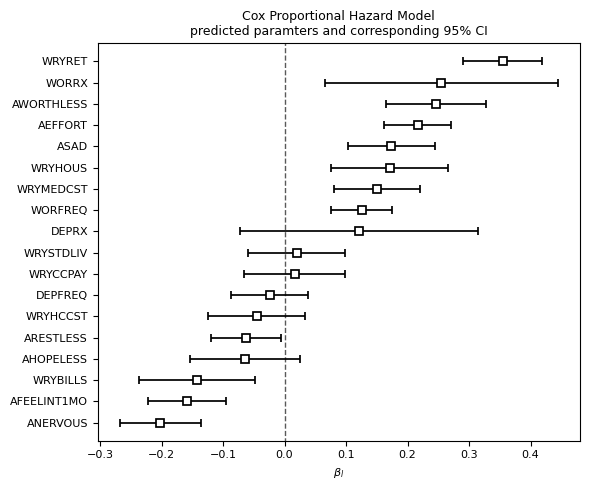

In [19]:
plt.subplots(figsize = (6, 5))
cph.plot()
plt.tight_layout()
plt.title(f'Cox Proportional Hazard Model\npredicted paramters and corresponding 95% CI', fontsize=9)
plt.xlabel(r'$\beta_l$', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig('mental_cox.png', format='png')
plt.show()

In [20]:
# CV for M1 

In [21]:
def cross_validate_cph(df, k, i):
    
    # intialize
    kf = KFold(n_splits=k, shuffle=True, random_state=20)
    # empty list for k-fold log-losses
    losses = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(df)):
        train_df, test_df = df.iloc[train_idx], df.iloc[test_idx]

        # fit Cox model
        cph = CoxPHFitter()
        cph.fit(train_df, duration_col='TIMETOEVENT', event_col='MORTSTAT')

        # compute survival probabilities for all test samples
        probabilities = cph.predict_survival_function(test_df)

        # extract the survival probabilities at time point i
        probabilities_i = probabilities.iloc[i]  
        
        # extract event status after time i
        events_i = np.where((test_df["MORTSTAT"] == 1) & (test_df["TIMETOEVENT"] <= i), 0, 1)

        # store log-loss for current fold
        log_loss_i = log_loss(events_i, probabilities_i)
    
        losses.append(log_loss_i)

    return losses

In [22]:
surv_1_cox_cv = cross_validate_cph(df[mental_w + mental_med + mental_freq + 
                                     mental_a + mental_a_infer + ['TIMETOEVENT', 'MORTSTAT']], k=5, i=1)

print(f'Log-loss cv 1y cox: {np.mean(surv_1_cox_cv):.4f}')

Log-loss cv 1y cox: 0.0695


In [23]:
surv_3_cox_cv = cross_validate_cph(df[mental_w + mental_med + mental_freq + 
                                     mental_a + mental_a_infer + ['TIMETOEVENT', 'MORTSTAT']], k=5, i=3)

print(f'Log-loss cv 3y cox: {np.mean(surv_3_cox_cv):.4f}')

Log-loss cv 3y cox: 0.1241


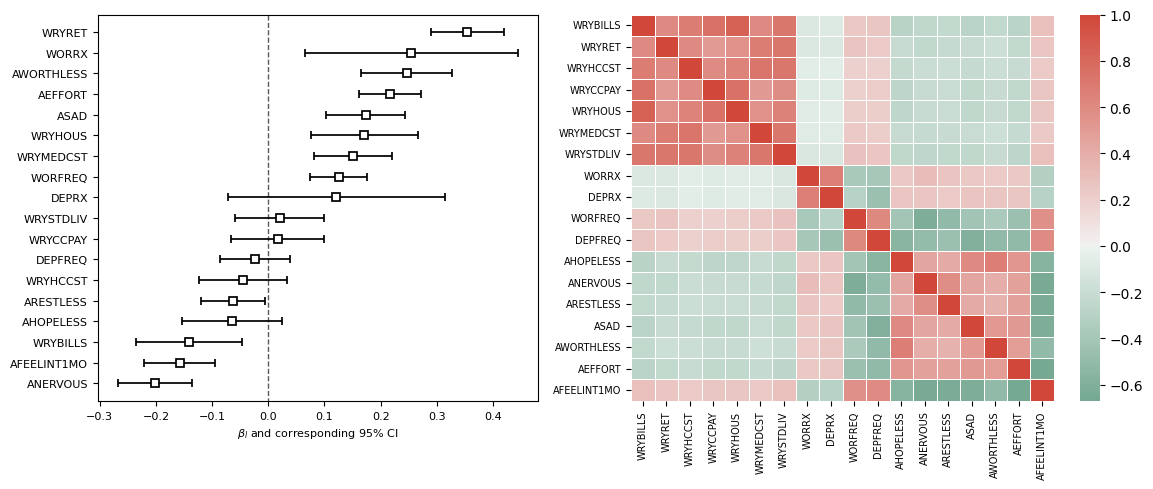

In [25]:
# plot from thesis
fig, axes = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [5, 6]})

# plot the correlation heatmap on the first subplot
corr_matrix = df[mental_w + mental_med + mental_freq + mental_a + mental_a_infer].corr()

sns.heatmap(corr_matrix, annot=False, cmap=sns.diverging_palette(150, 15, as_cmap=True), linewidths=0.5, center=0, ax=axes[1])
axes[1].tick_params(axis='x', labelsize=7)
axes[1].tick_params(axis='y', labelsize=7)

# plot the Cox proportional hazards model on the second subplot
cph.plot(ax=axes[0])
axes[0].set_xlabel(r'$\beta_l$ and corresponding 95% CI', fontsize=8)
axes[0].tick_params(axis='x', labelsize=8)
axes[0].tick_params(axis='y', labelsize=8)


plt.subplots_adjust(wspace=1.6)
plt.tight_layout()
plt.savefig('corr_mental.png', format='png')
plt.show()

In [ ]:
# M2 and M4

In [40]:
# define on-year mortalitty status
df.loc[:,'MORTSTAT_1Y'] = np.where((df['MORTDODY'] - df['YEAR']) <= 1, 1, 0)
df_train.loc[:,'MORTSTAT_1Y'] = np.where((df_train['MORTDODY'] - df_train['YEAR']) <= 1, 1, 0)
df_test.loc[:,'MORTSTAT_1Y'] = np.where((df_test['MORTDODY'] - df_test['YEAR']) <= 1, 1, 0)

In [89]:
# select features and target
X_train_1y = df_train[mental_w + mental_med + mental_freq + mental_a + mental_a_infer]
y_train_1y = df_train['MORTSTAT_1Y']

X_test_1y = df_test[mental_w + mental_med + mental_freq + mental_a + mental_a_infer]
y_test_1y = df_test['MORTSTAT_1Y']

In [169]:
model_1y_name = 'XGBClassifier'
#model_1y = DecisionTreeClassifier(class_weight='balanced', random_state=42)
#model_1y = GradientBoostingClassifier(n_estimators=50, learning_rate=0.2, random_state=10)
model_1y = xgb.XGBClassifier(n_estimators=30, learning_rate=0.1, random_state=42)
#model_1y = RandomForestClassifier(class_weight='balanced', n_estimators=1000, random_state=42)

# train
model_1y.fit(X_train_1y, y_train_1y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [170]:
# get predicted probabilities
y_pred_proba_train_1y = model_1y.predict_proba(X_train_1y)
y_pred_proba_test_1y = model_1y.predict_proba(X_test_1y)
# compute Log Loss
logloss_train_1y = log_loss(y_train_1y, y_pred_proba_train_1y)
logloss_test_1y = log_loss(y_test_1y, y_pred_proba_test_1y)

print(f'Log Loss is: {logloss_train_1y:.4f}')
print(f'Log Loss os: {logloss_test_1y:.4f}')

Log Loss is: 0.0660
Log Loss os: 0.0725


In [171]:
# CV loss
log_loss_scorer = make_scorer(log_loss, response_method='predict_proba')
cv_scores_1y = cross_val_score(model_1y, df[mental_w + mental_med + mental_freq + 
                                     mental_a + mental_a_infer], df['MORTSTAT_1Y'], cv=5, scoring=log_loss_scorer)

print(f"Cross-validation log-loss: {np.mean(cv_scores_1y)} ± {np.std(cv_scores_1y)}")

Cross-validation log-loss: 0.07112566294681184 ± 0.000565800539665119


In [172]:
# get feature importances
importances = model_1y.feature_importances_

# create a DataFrame for feature importance
feature_importance_df_1y = pd.DataFrame({
    'Feature': X_train_1y.columns,
    'Importance': importances
})

# sort the DataFrame by importance
feature_importance_df_1y = feature_importance_df_1y.sort_values(by='Importance', ascending=False)

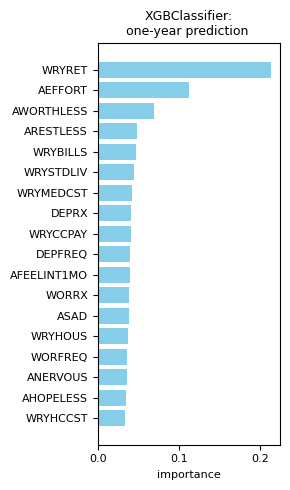

In [173]:
# plot feature importance
plt.figure(figsize=(3, 5))
plt.barh(feature_importance_df_1y['Feature'], feature_importance_df_1y['Importance'], color='skyblue')
plt.xlabel('importance', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title(f'{model_1y_name}:\none-year prediction ', fontsize=9)
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.savefig(f'mental_one_year_{model_1y_name}_without_age.jpg', format='jpg')
plt.show()

In [ ]:
# M3 and M5 

In [73]:
# we can use only samples tracked at least 3 years
df_3 = df[df['YEAR']<=2016] 

In [74]:
# define three-year mortalitty status
df_3 = df_3.copy()  # Ensure df_3 is a copy, not a slice
df_3.loc[:, 'MORTSTAT_3Y'] = np.where((df_3['MORTDODY'] - df_3['YEAR']) <= 3, 1, 0)

In [75]:
# split data into trainign and test set
df_3_train, df_3_test = train_test_split(df_3, test_size=0.2, random_state=21)

In [76]:
# select features and target
X_train_3y = df_3_train[mental_w + mental_med + mental_freq + mental_a + mental_a_infer]
y_train_3y = df_3_train['MORTSTAT_3Y']

X_test_3y = df_3_test[mental_w + mental_med + mental_freq + mental_a + mental_a_infer]
y_test_3y = df_3_test['MORTSTAT_3Y']

In [137]:
model_3y_name = 'GradientBoostingClassifier'
#model_3y = DecisionTreeClassifier(class_weight='balanced', random_state=42)
model_3y = GradientBoostingClassifier(n_estimators=30, learning_rate=0.2, random_state=10)
#model_3y = xgb.XGBClassifier(n_estimators=40, learning_rate=0.2, max_depth=2, random_state=42)
#model_3y = RandomForestClassifier(class_weight='balanced', n_estimators=1000, random_state=42)

# train
model_3y.fit(X_train_3y, y_train_3y)

GradientBoostingClassifier(learning_rate=0.2, n_estimators=30, random_state=10)

In [138]:
# get predicted probabilities
y_pred_proba_train_3y = model_3y.predict_proba(X_train_3y)
y_pred_proba_test_3y = model_3y.predict_proba(X_test_3y)

# compute Log Loss
logloss_train_3y = log_loss(y_train_3y, y_pred_proba_train_3y)
logloss_test_3y = log_loss(y_test_3y, y_pred_proba_test_3y)

print(f'Log Loss is: {logloss_train_3y:.4f}')
print(f'Log Loss os: {logloss_test_3y:.4f}')

Log Loss is: 0.1357
Log Loss os: 0.1507


In [84]:
# CV loss
log_loss_scorer = make_scorer(log_loss, response_method='predict_proba')
cv_scores_3y = cross_val_score(model_3y, df_3[mental_w + mental_med + mental_freq + mental_a + mental_a_infer],
                            df_3['MORTSTAT_3Y'], cv=5, scoring=log_loss_scorer)

print(f"Cross-validation log-loss: {np.mean(cv_scores_3y)} ± {np.std(cv_scores_3y)}")

Cross-validation log-loss: 0.14250838395500526 ± 0.0010922537892276176


In [85]:
# get feature importances
importances_3y = model_3y.feature_importances_

# create a DataFrame for feature importance
feature_importance_df_3y = pd.DataFrame({
    'Feature': X_train_3y.columns,
    'Importance': importances_3y
})

# sort the DataFrame by importance
feature_importance_df_3y = feature_importance_df_3y.sort_values(by='Importance', ascending=False)

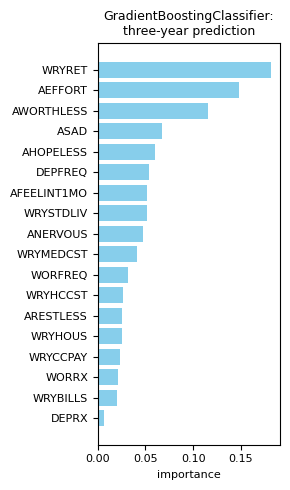

In [88]:
# plot feature importance
plt.figure(figsize=(3, 5))
plt.barh(feature_importance_df_3y['Feature'], feature_importance_df_3y['Importance'], color='skyblue')
plt.xlabel('importance', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title(f'{model_3y_name}:\nthree-year prediction', fontsize=9)
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.savefig(f'mental_three_year_{model_3y_name}_without_age.jpg', format='jpg')
plt.show()

In [53]:
# M6

In [24]:
# split dataset
df_surv_train, df_surv_test = train_test_split(df, test_size=0.2, random_state=42)

# select features
X_surv_train = df_surv_train[mental_w + mental_med + mental_freq + mental_a + mental_a_infer]
X_surv_test = df_surv_test[mental_w + mental_med + mental_freq + mental_a + mental_a_infer]
# select target
y_surv_train = np.array([(event, time) for event, time in zip(df_surv_train['MORTSTAT'], df_surv_train['TIMETOEVENT'])], dtype=[('event', bool), ('time', float)])
y_surv_test = np.array([(event, time) for event, time in zip(df_surv_test['MORTSTAT'], df_surv_test['TIMETOEVENT'])], dtype=[('event', bool), ('time', float)])

# fit
model_surv = RandomSurvivalForest(n_estimators=100, min_samples_split=10, max_depth=5, random_state=42)
model_surv.fit(X_surv_train, y_surv_train)

RandomSurvivalForest(max_depth=5, min_samples_split=10, random_state=42)

In [25]:
# predict survival function
surv_probs_train = model_surv.predict_survival_function(X_surv_train)
surv_probs_test = model_surv.predict_survival_function(X_surv_test)

# all time-to-event points
time_points_train = surv_probs_train[0].x
time_points_test = surv_probs_test[0].x 
 
# convert survival probabilities to df
df_surv_probs_train = pd.DataFrame(
    data=[fn(time_points_train) for fn in surv_probs_train],  
    columns=time_points_train)
df_surv_probs_test = pd.DataFrame(
    data=[fn(time_points_train) for fn in surv_probs_test],  
    columns=time_points_train)

In [27]:
# surv probabilites after 1 and 3 years
suvr_prob_1y_train = df_surv_probs_train.iloc[:,1]  
suvr_prob_1y_test = df_surv_probs_test.iloc[:,1]  
suvr_prob_3y_train = df_surv_probs_train.iloc[:,3]
suvr_prob_3y_test = df_surv_probs_test.iloc[:,3]

# extract status
# get 1-year event status based on TIMETOEVENT and MORTSTAT
status_1y_train_surv = np.where((df_surv_train["MORTSTAT"] == 1) & (df_surv_train["TIMETOEVENT"] <= 1), 0, 1)
status_1y_test_surv = np.where((df_surv_test["MORTSTAT"] == 1) & (df_surv_test["TIMETOEVENT"] <= 1), 0, 1)
# get 3-year event status based on TIMETOEVENT and MORTSTAT
status_3y_train_surv = np.where((df_surv_train["MORTSTAT"] == 1) & (df_surv_train["TIMETOEVENT"] <= 3), 0, 1)
status_3y_test_surv = np.where((df_surv_test["MORTSTAT"] == 1) & (df_surv_test["TIMETOEVENT"] <= 3), 0, 1)

# log-loss
log_loss_1y_train = log_loss(status_1y_train_surv, suvr_prob_1y_train)
log_loss_1y_test = log_loss(status_1y_test_surv, suvr_prob_1y_test)
log_loss_3y_train = log_loss(status_3y_train_surv, suvr_prob_3y_train)
log_loss_3y_test = log_loss(status_3y_test_surv, suvr_prob_3y_test)

print(f'Log Loss 1y is: {log_loss_1y_train:.4f}')
print(f'Log Loss 1y is: {log_loss_1y_test:.4f}')
print(f'Log Loss 3y is: {log_loss_3y_train:.4f}')
print(f'Log Loss 3y is: {log_loss_3y_test:.4f}')

Log Loss 1y is: 0.0675
Log Loss 1y is: 0.0743
Log Loss 3y is: 0.1220
Log Loss 3y is: 0.1280


In [ ]:
# CV for M6

In [28]:
def cross_validate_SURV(df, k, i):
    
    kf = KFold(n_splits=k, shuffle=True, random_state=21)
    losses = [] 
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(df)):
        train_df, test_df = df.iloc[train_idx], df.iloc[test_idx]
        
        # select features
        X_surv_train = train_df[mental_w + mental_med + mental_freq + mental_a + mental_a_infer]
        X_surv_test = test_df[mental_w + mental_med + mental_freq + mental_a + mental_a_infer]
        
        # select target
        y_surv_train = np.array([(event, time) for event, time in zip(train_df['MORTSTAT'], train_df['TIMETOEVENT'])], 
                                 dtype=[('event', bool), ('time', float)])
        y_surv_test = np.array([(event, time) for event, time in zip(test_df['MORTSTAT'], test_df['TIMETOEVENT'])], 
                                dtype=[('event', bool), ('time', float)])

        # fit 
        model_surv_k = RandomSurvivalForest(n_estimators=100, min_samples_split=10, max_depth=5, random_state=42)
        model_surv_k.fit(X_surv_train, y_surv_train)

        # compute survival function for all test samples
        probabilities_i = model_surv_k.predict_survival_function(X_surv_test)

        # extract time-to-events points and ensure i is valid
        time_points = probabilities_i[0].x

        # make df from survial functions
        df_probabilities_i = pd.DataFrame(data=[fn(time_points) for fn in probabilities_i], columns=time_points)

        # select survival probabilities at the requested time point
        surv_prob_i = df_probabilities_i.iloc[:,i]

        # extract event status after time i 
        events_i = np.where((test_df["MORTSTAT"] == 1) & (test_df["TIMETOEVENT"] <= i), 0, 1)

        # compute log-loss for current fold
        log_loss_i = log_loss(events_i, surv_prob_i)
    
        losses.append(log_loss_i)

    return losses

In [29]:
surv_1_cv = cross_validate_SURV(df, k=5, i=1)

print(f'Log-loss cv 1y cox: {np.mean(surv_1_cv):.4f}')

Log-loss cv 1y cox: 0.0697


In [30]:
surv_3_cv = cross_validate_SURV(df, k=5, i=3)

print(f'Log-loss cv 3y cox: {np.mean(surv_3_cv):.4f}')

Log-loss cv 3y cox: 0.1244


In [ ]:
# compute imporances for M6

In [64]:
def compute_feature_importance_logloss(model, X, y, i, n_repeats=10):

    # compute baseline survival probabilities at the specified time point
    surv_probs = model.predict_survival_function(X)
    probs_i = np.array([fn(i) for fn in surv_probs]) 
    
    # compute observed event status at the given time point
    event_status_i = np.array([1 if time <= i else 0 for time in y['time']])

    # compute baseline log-loss
    baseline_logloss = log_loss(event_status_i, probs_i)

    feature_importance = []

    for col in X.columns:
        permuted_logloss = []
        print(col)
        for _ in range(n_repeats):
            X_permuted = X.copy()
            X_permuted[col] = np.random.permutation(X_permuted[col])  # shuffle one feature
            
            # compute new survival probabilities
            permuted_probs = model.predict_survival_function(X_permuted)
            permuted_probs = np.array([fn(i) for fn in permuted_probs])

            # compute log-loss after permutation
            logloss_permuted = log_loss(event_status_i, permuted_probs)
            permuted_logloss.append(logloss_permuted)

        # feature importance as mean decrease in log-loss
        importance_score = abs(np.mean(permuted_logloss) - baseline_logloss)
        feature_importance.append((col, importance_score))

    # convert to DataFrame
    importance_df = pd.DataFrame(feature_importance, columns=["Feature", "Importance"])
    importance_df = importance_df.sort_values(by="Importance", ascending=False)

    return importance_df

In [65]:
# compute feature importance using log-loss at 3 year 
feature_importance_df_surv = compute_feature_importance_logloss(model_surv, X_surv_train, y_surv_train, i=3, n_repeats=10)

WRYBILLS
WRYRET
WRYHCCST
WRYCCPAY
WRYHOUS
WRYMEDCST
WRYSTDLIV
WORRX
DEPRX
WORFREQ
DEPFREQ
AHOPELESS
ANERVOUS
ARESTLESS
ASAD
AWORTHLESS
AEFFORT
AFEELINT1MO


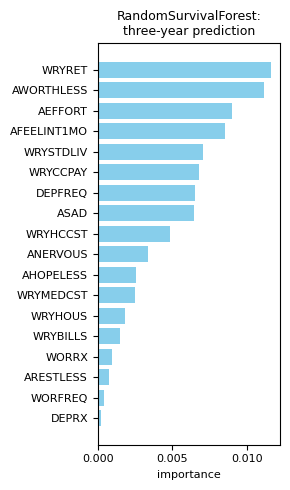

In [72]:
# plot feature importance
plt.figure(figsize=(3, 5))
plt.barh(feature_importance_df_surv['Feature'], feature_importance_df_surv['Importance'], color='skyblue')
plt.xlabel('importance', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title(f'RandomSurvivalForest:\nthree-year prediction', fontsize=9)
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.savefig(f'mental_three_year_RandomSurvivalForest_without_age.jpg', format='jpg')
plt.show()

In [ ]:
# find bins based on log-rank statistics

In [ ]:
# List of features to analyze
features = mental_w + mental_freq + mental_a + mental_a_infer
# Dictionary to store best cut points
best_cut_points = {}

for feature in features:
    # Get candidate cut points
    sorted_values = sorted(df[feature].dropna().unique())  # Drop NaN values before sorting

    best_cut_point = None
    max_abs_log_rank_stat = 0

    for i in range(1, len(sorted_values)):
        # Split at current cut point
        group1 = df[df[feature] <= sorted_values[i]]
        group2 = df[df[feature] > sorted_values[i]]

        # Perform log-rank test
        results = logrank_test(group1['TIMETOEVENT'], group2['TIMETOEVENT'], 
                               event_observed_A=group1['MORTSTAT'], event_observed_B=group2['MORTSTAT'])
        l_r_stat = results.test_statistic  

        # Compare values of log-rank statistics
        if l_r_stat > max_abs_log_rank_stat:
            best_cut_point = sorted_values[i]
            max_abs_log_rank_stat = l_r_stat

    # Store the best cut point
    best_cut_points[feature] = best_cut_point

# Print results
for feature, cut_point in best_cut_points.items():
    print(f"Best cut point for {feature}: {cut_point}")

In [ ]:
# Convert the best cut points dictionary to a DataFrame
best_cut_points_df = pd.DataFrame(list(best_cut_points.items()), columns=['Feature', 'Best Cut Point'])

# Set the feature names as the index for better readability
best_cut_points_df.set_index('Feature', inplace=True)

# Plot the heatmap
plt.figure(figsize=(2, 5))  # Adjust figure size as needed
sns.heatmap(best_cut_points_df, annot=True, cmap=sns.diverging_palette(250, 70, as_cmap=True), cbar=False, linewidths=0.5, annot_kws={'size': 10})

# Add title and labels
plt.xlabel("Features", fontsize=8)
plt.ylabel("Best Cut Point", fontsize=8)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()